In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPTokenizer, CLIPModel
from sklearn.metrics import accuracy_score

from transformers import CLIPModel, CLIPTextModel, CLIPTokenizer

import time
import psutil

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# 准备数据集
transform_cifar10_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['automobile', 'airplane', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataset_name = 'CIFAR10'

Files already downloaded and verified


In [5]:
# 准备text
prompt = "This is a"
text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)

In [6]:
def model_inference(model, image):
    """
    Perform one testing batch iteration.
    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.
    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """
    ##################### Write your answer here ##################
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp()

    logits = logit_scale * image_features @ text_features.t()
    ###############################################################
    return logits

In [ ]:
# 直接使用clip进行zero-shot

In [7]:
# Load the model
VISUAL_BACKBONE = 'RN50' # RN50, ViT-B/32, ViT-B/16
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device)
model.to(device)
# zero-shot
testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    
    for batch_idx, (image, target) in enumerate(test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)

    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

the zero-shot performance on CIFAR10 is 42.97%, visual encoder is RN50.


In [8]:
# Load the model
VISUAL_BACKBONE = 'ViT-B/32' # RN50, ViT-B/32, ViT-B/16
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device)
model.to(device)
# zero-shot
testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    
    for batch_idx, (image, target) in enumerate(test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)

    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

the zero-shot performance on CIFAR10 is 68.45%, visual encoder is ViT-B/32.


In [9]:
# Load the model
VISUAL_BACKBONE = 'ViT-B/16' # RN50, ViT-B/32, ViT-B/16
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device)
model.to(device)
# zero-shot
testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    
    for batch_idx, (image, target) in enumerate(test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)

    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

the zero-shot performance on CIFAR10 is 69.59%, visual encoder is ViT-B/16.


In [ ]:
开始使用ResNet50，不处理最后一层，直接使用

In [ ]:
# 加载RN50在预训练过程中的1000个类别，判断与cifar10中的类别是否存在重合
# 加载预训练的 ResNet-50 模型
import torchvision.models as models
import requests

model = models.resnet50(pretrained=True)

# 获取 ImageNet 类别名称的 URL
imagenet_classes_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# 下载并加载类别名称
response = requests.get(imagenet_classes_url)
RN50_class_names = response.json()

cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for name in cifar10_class_names:
    if name in RN50_class_names:
        print(name, "in cifar10,", "is also in RN50_class_names")
    else:
        print(name, "in cifar10,", "is not in RN50_class_names")
        
if set(RN50_class_names) & set(cifar10_class_names):
    print("存在重合")
else:
    print("不存在重合")

In [ ]:
没有直接预测的必要

In [ ]:
训练ResNet50，对ResNet50最后一层进行处理1000——10

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# 设定设备
device = "cuda" if torch.cuda.is_available() else "cpu"

# 数据预处理
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载 CIFAR-10 数据集
batch_size = 128
train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)


# 加载预训练的 ResNet-50 模型
model = models.resnet50(pretrained=True)

# 替换最后的全连接层以匹配 CIFAR-10 的类别数 (10)
model.fc = nn.Linear(model.fc.in_features, 10)

# 将模型发送到设备
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# 每个epoch记录一下train和test的acc和loss

# 记录每个 epoch 的准确度和损失
train_losses = []  # 训练集上的loss
train_accuracies = []    # 训练集上的acc
test_losses = []   # 测试集上的loss
test_accuracies = [] # 测试集上的acc

# 训练模型
num_epochs = 10

for epoch in range(num_epochs):
    
    ######################################################################
    start_time = time.time()

    initial_gpu_memory = torch.cuda.memory_allocated()
    initial_gpu_memory_cache = torch.cuda.memory_reserved()
    ########################################################
    
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # 每 2000 批次打印一次
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    # 计算并记录每个 epoch 的训练损失和训练准确度
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch {epoch + 1}, Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.2f}%')

    ##########################################################
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training time: {total_time:.2f} seconds")
    
    final_gpu_memory = torch.cuda.memory_allocated()
    final_gpu_memory_cache = torch.cuda.memory_reserved()
    print(f"GPU memory used: {final_gpu_memory - initial_gpu_memory} bytes")
    print(f"GPU memory cache: {final_gpu_memory_cache - initial_gpu_memory_cache} bytes")
    ##############################################################################

    # 在测试集上测试模型
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    # 计算并记录每个 epoch 的测试损失和准确度
    test_loss = test_loss / len(test_dataloader)
    test_losses.append(test_loss)
    accuracy = 100 * correct_test / total_test
    test_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}, Testing Loss: {test_loss:.3f}, Accuracy: {accuracy:.2f}%')

#     print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

print('Finished training and testing!')

Epoch 1, Training Loss: 1.263, Training Accuracy: 55.52%
Training time: 20.83 seconds
GPU memory used: 200301568 bytes
GPU memory cache: 50331648 bytes
Epoch 1, Testing Loss: 0.850, Accuracy: 70.32%
Epoch 2, Training Loss: 0.765, Training Accuracy: 73.30%
Training time: 20.55 seconds
GPU memory used: 3584 bytes
GPU memory cache: 0 bytes
Epoch 2, Testing Loss: 0.699, Accuracy: 76.03%
Epoch 3, Training Loss: 0.637, Training Accuracy: 77.91%
Training time: 20.46 seconds
GPU memory used: 3584 bytes
GPU memory cache: 0 bytes
Epoch 3, Testing Loss: 0.633, Accuracy: 78.66%
Epoch 4, Training Loss: 0.559, Training Accuracy: 80.50%
Training time: 20.43 seconds
GPU memory used: 3584 bytes
GPU memory cache: 0 bytes
Epoch 4, Testing Loss: 0.586, Accuracy: 80.09%
Epoch 5, Training Loss: 0.502, Training Accuracy: 82.55%
Training time: 20.42 seconds
GPU memory used: 3584 bytes
GPU memory cache: 0 bytes
Epoch 5, Testing Loss: 0.549, Accuracy: 81.51%
Epoch 6, Training Loss: 0.458, Training Accuracy: 84.

In [20]:
print("This is the losses during the training", train_losses, "\n")
print("This is the accuracies during the training", train_accuracies, "\n")
print("This is the losses during the testing", test_losses, "\n")
print("This is the accuracies during the testing", test_accuracies, "\n")

This is the losses during the training [1.2629457576500485, 0.7647699090221044, 0.6374699798081537, 0.5594700205966335, 0.5020830824856868, 0.4579552922712263, 0.4218782549700164, 0.38457601576509987, 0.3655237842475057, 0.33381875187082366] 

This is the accuracies during the training [55.52, 73.304, 77.908, 80.5, 82.546, 84.164, 85.232, 86.52, 87.224, 88.406] 

This is the losses during the testing [0.8503681926787654, 0.6985623447955409, 0.6334442541569094, 0.5855103734927841, 0.5490107909788059, 0.5304075558728809, 0.5212985941126377, 0.5138863989069492, 0.5030311968507646, 0.5120128046108198] 

This is the accuracies during the testing [70.32, 76.03, 78.66, 80.09, 81.51, 82.08, 82.29, 82.97, 83.21, 83.25] 



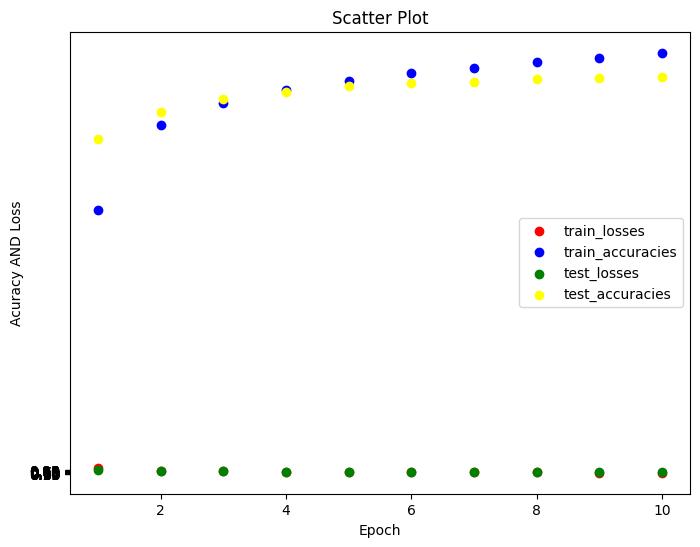

In [21]:
plt.figure(figsize=(8, 6))

x = torch.arange(1, 11)

plt.scatter(x, train_losses, color='red', label='train_losses')
plt.scatter(x, train_accuracies, color='blue', label='train_accuracies')
plt.scatter(x, test_losses, color='green', label='test_losses')
plt.scatter(x, test_accuracies, color='yellow', label='test_accuracies')

plt.title("Scatter Plot")
plt.xlabel("Epoch")
plt.ylabel("Acuracy AND Loss")

plt.yticks(np.arange(0, 1, 0.05))

plt.legend()

plt.show()

In [ ]:
训练clip

In [ ]:
!pip install torch torchvision transformers # 运行过了

In [6]:
# 设置随机种子以保证结果的可重复性
torch.manual_seed(100)

# 初始化CLIP模型和处理器，并指定视觉骨干为ResNet-50
VISUAL_BACKBONE = 'RN50' # RN50, ViT-B/32, ViT-B/16
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load the model
model, processor = clip.load(name=VISUAL_BACKBONE, device=device)
model.to(device)

# 数据预处理
transform_cifar10_train = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载 CIFAR-10 数据集
BATCH_SIZE = 32
train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Files already downloaded and verified


In [7]:
# 训练参数
num_epochs = 3

# 训练循环
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    predictions = []
    ground_truths = []
    
    ###############################################################################
    start_time = time.time()

    initial_gpu_memory = torch.cuda.memory_allocated()
    initial_gpu_memory_cache = torch.cuda.memory_reserved()
    #####################################################################################################################
    
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # 文本预处理
        text_descriptions = ["a photo of a " + str(label) for label in labels.tolist()]
        text_inputs = clip.tokenize(text_descriptions).to(device)
        # 图像预处理-注意：图像已经通过 DataLoader 和 transform_cifar10_train 进行了预处理-因此，这里不需要额外的图像处理代码
        
        # 训练过程
        optimizer.zero_grad()
        # 将处理后的图像和文本输入传递给模型
        image_features = model.encode_image(images)
        text_features = model.encode_text(text_inputs)
        # 计算损失
        logits_per_image = model.logit_scale.exp() * image_features @ text_features.t()
        loss = criterion(logits_per_image, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()        
        # 记录预测和真实标签
        predictions.extend(logits_per_image.argmax(1).cpu().tolist())
        ground_truths.extend(labels.cpu().tolist())

    # 计算准确度
    accuracy = accuracy_score(ground_truths, predictions)

    # 打印每个epoch的损失和准确度
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {total_loss / len(train_dataloader):.4f} Accuracy: {accuracy:.4f}")

    ##########################################################
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training time: {total_time:.2f} seconds")
    
    final_gpu_memory = torch.cuda.memory_allocated()
    final_gpu_memory_cache = torch.cuda.memory_reserved()
    print(f"GPU memory used: {final_gpu_memory - initial_gpu_memory} bytes")
    print(f"GPU memory cache: {final_gpu_memory_cache - initial_gpu_memory_cache} bytes")
    ##############################################################################
    
# 保存训练后的模型权重
model.save_pretrained("clip_cifar10_finetuned")
tokenizer.save_pretrained("clip_cifar10_finetuned")

Epoch [1/3] Loss: nan Accuracy: 0.1000
Training time: 457.18 seconds
GPU memory used: 811683328 bytes
GPU memory cache: 3248488448 bytes
Epoch [2/3] Loss: nan Accuracy: 0.1000
Training time: 450.12 seconds
GPU memory used: 0 bytes
GPU memory cache: 0 bytes
Epoch [3/3] Loss: nan Accuracy: 0.1000
Training time: 448.74 seconds
GPU memory used: 0 bytes
GPU memory cache: 0 bytes


AttributeError: 'CLIP' object has no attribute 'save_pretrained'